In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss

# Reload datasets
men_results = pd.read_csv("MRegularSeasonCompactResults.csv")
women_results = pd.read_csv("WRegularSeasonCompactResults.csv")

tourney_results_men = pd.read_csv("MNCAATourneyCompactResults.csv")
tourney_results_women = pd.read_csv("WNCAATourneyCompactResults.csv")

sample_submission_1 = pd.read_csv("SampleSubmissionStage1.csv")
sample_submission_2 = pd.read_csv("SampleSubmissionStage2.csv")

# Combine submission files
sample_submission = pd.concat([sample_submission_1, sample_submission_2], ignore_index=True)

### ---------------- STEP 1: Calculate Elo Ratings for Both Men & Women ---------------- ###

BASE_ELO = 1500
K_FACTOR = 30

def calculate_elo(results):
    """Calculate Elo ratings for a dataset."""
    elo_ratings = {}
    # BASE_ELO = 1500
    # K_FACTOR = 30

    def expected_score(elo_a, elo_b):
        return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

    def update_elo(winner_elo, loser_elo):
        expected_win = expected_score(winner_elo, loser_elo)
        new_winner_elo = winner_elo + K_FACTOR * (1 - expected_win)
        new_loser_elo = loser_elo + K_FACTOR * (0 - (1 - expected_win))
        return new_winner_elo, new_loser_elo

    for _, row in results.iterrows():
        w_team, l_team = row["WTeamID"], row["LTeamID"]

        if w_team not in elo_ratings:
            elo_ratings[w_team] = BASE_ELO
        if l_team not in elo_ratings:
            elo_ratings[l_team] = BASE_ELO

        w_elo, l_elo = elo_ratings[w_team], elo_ratings[l_team]
        new_w_elo, new_l_elo = update_elo(w_elo, l_elo)
        elo_ratings[w_team] = new_w_elo
        elo_ratings[l_team] = new_l_elo

    return elo_ratings

# Compute Elo ratings for men and women
elo_ratings_men = calculate_elo(men_results)
elo_ratings_women = calculate_elo(women_results)


In [ ]:
### ---------------- STEP 2: Prepare Training Data ---------------- ###

def prepare_dataset(tourney_results, elo_ratings):
    """Prepares dataset by merging Elo ratings and balancing matchups."""
    
    # Merge Elo ratings
    tourney_results["WTeamElo"] = tourney_results["WTeamID"].map(elo_ratings)
    tourney_results["LTeamElo"] = tourney_results["LTeamID"].map(elo_ratings)
    
    # Compute Elo difference
    tourney_results["EloDiff"] = tourney_results["WTeamElo"] - tourney_results["LTeamElo"]
    
    # Assign target label (1 = WTeam won, 0 = LTeam won)
    tourney_results["Outcome"] = 1
    
    # Create a balanced dataset (Team A vs. Team B and vice versa)
    matchups = tourney_results[["Season", "WTeamID", "LTeamID", "WTeamElo", "LTeamElo", "EloDiff", "Outcome"]]
    matchups.rename(columns={"WTeamID": "TeamA", "LTeamID": "TeamB", "WTeamElo": "TeamA_Elo", "LTeamElo": "TeamB_Elo"}, inplace=True)
    
    matchups_reversed = matchups.copy()
    matchups_reversed["TeamA"], matchups_reversed["TeamB"] = matchups["TeamB"], matchups["TeamA"]
    matchups_reversed["TeamA_Elo"], matchups_reversed["TeamB_Elo"] = matchups["TeamB_Elo"], matchups["TeamA_Elo"]
    matchups_reversed["EloDiff"] = -matchups["EloDiff"]
    matchups_reversed["Outcome"] = 0
    
    return pd.concat([matchups, matchups_reversed], ignore_index=True)

# Prepare datasets
final_dataset_men = prepare_dataset(tourney_results_men, elo_ratings_men)
final_dataset_women = prepare_dataset(tourney_results_women, elo_ratings_women)


/var/folders/gg/9yqnf79d0j54m7_g2f4f2ycw0000gn/T/ipykernel_55940/1980292470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchups.rename(columns={"WTeamID": "TeamA", "LTeamID": "TeamB", "WTeamElo": "TeamA_Elo", "LTeamElo": "TeamB_Elo"}, inplace=True)
/var/folders/gg/9yqnf79d0j54m7_g2f4f2ycw0000gn/T/ipykernel_55940/1980292470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchups.rename(columns={"WTeamID": "TeamA", "LTeamID": "TeamB", "WTeamElo": "TeamA_Elo", "LTeamElo": "TeamB_Elo"}, inplace=True)


In [7]:
### ---------------- STEP 3.1: Train XGBoost Models ---------------- ###

def train_xgboost(dataset):
    """Trains and optimizes XGBoost model using RandomizedSearchCV."""
    feature_cols = ["TeamA_Elo", "TeamB_Elo", "EloDiff"]
    target_col = "Outcome"

    X_train, X_test, y_train, y_test = train_test_split(dataset[feature_cols], dataset[target_col], test_size=0.2, random_state=42, stratify=dataset[target_col])

    param_dist = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05],
        "max_depth": [3, 5],
        "subsample": [0.6, 0.8],
        "colsample_bytree": [0.6, 0.8],
        "reg_alpha": [0.01, 0.1],
        "reg_lambda": [0.01, 0.1],
    }

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=5, cv=3, scoring="neg_log_loss", verbose=1, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    model_optimized = xgb.XGBClassifier(**best_params)
    model_optimized.fit(X_train, y_train)

    return model_optimized

# Train models for both datasets
model_men = train_xgboost(final_dataset_men)
model_women = train_xgboost(final_dataset_women)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/py

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:01:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/engraciadacosta/Desktop/MMLM_EngraciaBatista_Chrysalytics/venv/lib/py

In [ ]:
### ---------------- STEP 4: Generate Predictions for Submission ---------------- ###

def parse_matchup_id(matchup_id):
    """
    Extract season and team IDs from the matchup ID format SSSS_XXXX_YYYY.
    Handles malformed IDs safely to avoid errors.
    """
    try:
        # Ensure the ID is a string and remove spaces
        matchup_id = str(matchup_id).strip()
        
        # Split into parts (expected format: "2024_1101_1123")
        parts = matchup_id.split("_")
        
        # Check if we have exactly 3 parts
        if len(parts) != 3:
            print(f"Skipping malformed ID: {matchup_id}")
            return None, None, None
        
        # Convert to integers
        season, team1, team2 = int(parts[0]), int(parts[1]), int(parts[2])
        
        return season, team1, team2
    except Exception as e:
        print(f"Error parsing matchup ID {matchup_id}: {e}")
        return None, None, None

# Extract season, teamA, teamB from the "ID" column in the submission file
sample_submission[["Season", "TeamA", "TeamB"]] = sample_submission["ID"].apply(lambda x: pd.Series(parse_matchup_id(x)))

# Remove rows where the ID parsing failed
sample_submission.dropna(subset=["Season", "TeamA", "TeamB"], inplace=True)

def get_elo_and_model(season, team_a, team_b):
    """
    Determine if a matchup belongs to the men's or women's tournament
    based on available Elo ratings.
    """
    if team_a in elo_ratings_men and team_b in elo_ratings_men:
        return (elo_ratings_men, model_men)
    elif team_a in elo_ratings_women and team_b in elo_ratings_women:
        return (elo_ratings_women, model_women)
    return (None, None)  # Default case if no Elo rating is found

# Retrieve Elo ratings and predict probabilities for each matchup
predictions = []
for _, row in sample_submission.iterrows():
    season, team_a, team_b = row["Season"], row["TeamA"], row["TeamB"]
    elo_ratings, model = get_elo_and_model(season, team_a, team_b)
    
    if elo_ratings is not None:
        # Get Elo ratings, using BASE_ELO as default if team is missing
        team_a_elo = elo_ratings.get(team_a, BASE_ELO)
        team_b_elo = elo_ratings.get(team_b, BASE_ELO)
        
        # Calculate Elo difference (Team A - Team B)
        elo_diff = team_a_elo - team_b_elo

        # Create a feature dataframe for the model
        features = pd.DataFrame([[team_a_elo, team_b_elo, elo_diff]], columns=["TeamA_Elo", "TeamB_Elo", "EloDiff"])
        
        # Predict probability of Team A winning
        pred = model.predict_proba(features)[0][1]

        predictions.append(pred)
    else:
        # Default to 50% win probability if the matchup is unrecognized
        predictions.append(0.5)

# Store predictions in the submission format
sample_submission["Pred"] = predictions

# Keep only the required columns for final submission
final_predictions = sample_submission[["ID", "Pred"]]

# Save predictions to CSV file
final_predictions.to_csv("NCAA_FinalPredictions_EngraciaBatista.csv", index=False)


In [ ]:
### ---------------- STEP 4: Generate Predictions for Submission ---------------- ###

# Define BASE_ELO globally
BASE_ELO = 1500  # Default Elo for teams not found in the dataset

def parse_matchup_id(matchup_id):
    """
    Extract season and team IDs from the matchup ID format SSSS_XXXX_YYYY.
    Handles malformed IDs safely to avoid errors.
    """
    try:
        matchup_id = str(matchup_id).strip()
        parts = matchup_id.split("_")
        if len(parts) != 3:
            print(f"Skipping malformed ID: {matchup_id}")
            return None, None, None
        return int(parts[0]), int(parts[1]), int(parts[2])
    except Exception as e:
        print(f"Error parsing matchup ID {matchup_id}: {e}")
        return None, None, None

# Extract season, teamA, teamB from the "ID" column
sample_submission[["Season", "TeamA", "TeamB"]] = sample_submission["ID"].apply(lambda x: pd.Series(parse_matchup_id(x)))
sample_submission.dropna(subset=["Season", "TeamA", "TeamB"], inplace=True)  # Remove invalid rows

def get_tournament_label(team_a, team_b):
    """
    Determine if a matchup belongs to the men's or women's tournament
    based on available Elo ratings.
    """
    if team_a in elo_ratings_men and team_b in elo_ratings_men:
        return "Men"
    elif team_a in elo_ratings_women and team_b in elo_ratings_women:
        return "Women"
    return "Unknown"

# Assign tournament type to each matchup
sample_submission["Tournament"] = sample_submission.apply(lambda row: get_tournament_label(row["TeamA"], row["TeamB"]), axis=1)

# Retrieve Elo ratings and predict probabilities
predictions = []
for _, row in sample_submission.iterrows():
    season, team_a, team_b = row["Season"], row["TeamA"], row["TeamB"]
    elo_ratings, model = get_elo_and_model(season, team_a, team_b)
    
    if elo_ratings is not None:
        team_a_elo = elo_ratings.get(team_a, BASE_ELO)
        team_b_elo = elo_ratings.get(team_b, BASE_ELO)
        elo_diff = team_a_elo - team_b_elo

        features = pd.DataFrame([[team_a_elo, team_b_elo, elo_diff]], columns=["TeamA_Elo", "TeamB_Elo", "EloDiff"])
        pred = model.predict_proba(features)[0][1]

        predictions.append(pred)
    else:
        predictions.append(0.5)  # Default 50% probability if unknown teams

sample_submission["Pred"] = predictions

# Split Stage 1 and Stage 2 datasets
sample_submission_stage1 = sample_submission[sample_submission["ID"].isin(sample_submission_1["ID"])]
sample_submission_stage2 = sample_submission[sample_submission["ID"].isin(sample_submission_2["ID"])]

# Create separate files for men and women for each stage
final_predictions_men_stage1 = sample_submission_stage1[sample_submission_stage1["Tournament"] == "Men"][["ID", "Pred"]]
final_predictions_men_stage2 = sample_submission_stage2[sample_submission_stage2["Tournament"] == "Men"][["ID", "Pred"]]
final_predictions_women_stage1 = sample_submission_stage1[sample_submission_stage1["Tournament"] == "Women"][["ID", "Pred"]]
final_predictions_women_stage2 = sample_submission_stage2[sample_submission_stage2["Tournament"] == "Women"][["ID", "Pred"]]

# Concatenated predictions for all Men & Women matchups
final_predictions_concat = sample_submission[["ID", "Pred", "Tournament"]]

# Save CSV files with the requested names
final_predictions_men_stage1.to_csv("NCAA_FinalPredictions_MenStage1_EngraciaBatista.csv", index=False)
final_predictions_men_stage2.to_csv("NCAA_FinalPredictions_MenStage2_EngraciaBatista.csv", index=False)
final_predictions_women_stage1.to_csv("NCAA_FinalPredictions_WomenStage1_EngraciaBatista.csv", index=False)
final_predictions_women_stage2.to_csv("NCAA_FinalPredictions_WomenStage2_EngraciaBatista.csv", index=False)
final_predictions_concat.to_csv("NCAA_FinalPredictions_ConcatMenWomen_EngraciaBatista.csv", index=False)

print("Step 4: Done successfully!")

ModuleNotFoundError: No module named 'ace_tools'

In [2]:
### ---------------- STEP 4.2: Generate Final Submission File ---------------- ###

# ------------------- STEP 1: LOAD EXISTING PREDICTIONS ------------------- #

import pandas as pd

# Load men's and women's predictions (Stage 2)
df_preds_men = pd.read_csv("NCAA_FinalPredictions_MenStage2_EngraciaBatista.csv")
df_preds_women = pd.read_csv("NCAA_FinalPredictions_WomenStage2_EngraciaBatista.csv")

# Ensure both datasets have the correct columns
df_preds_men = df_preds_men[["ID", "Pred"]]
df_preds_women = df_preds_women[["ID", "Pred"]]

# ------------------- STEP 2: CONCATENATE MEN'S & WOMEN'S PREDICTIONS ------------------- #

# Merge both datasets into one
df_final_submission = pd.concat([df_preds_men, df_preds_women], ignore_index=True)

# ------------------- STEP 3: ENSURE PROPER FORMATTING ------------------- #

# The required format is: ID,Pred
# ID format should be "2025_TeamA_TeamB", where TeamA < TeamB
df_final_submission = df_final_submission[["ID", "Pred"]]

# ------------------- STEP 4: SAVE FINAL SUBMISSION FILE ------------------- #

# Save the final submission file
submission_filename = "NCAA_2025_FinalSubmission_EngraciaBatista_Chrysalytics.csv"
df_final_submission.to_csv(submission_filename, index=False)

print(f"Submission file generated successfully.")


Submission file generated successfully.


In [11]:
### ---------------- STEP 5: Enriching Stage 2 Predictions with Team Names & Elo Ratings ---------------- ###
# Load team names for men and women
teams_men = pd.read_csv("MTeams.csv")  # Contains "TeamID" and "TeamName"
teams_women = pd.read_csv("WTeams.csv")  # Contains "TeamID" and "TeamName"

# Load the Stage 2 predictions generated in Step 4
stage2_men = pd.read_csv("NCAA_FinalPredictions_MenStage2_EngraciaBatista.csv")
stage2_women = pd.read_csv("NCAA_FinalPredictions_WomenStage2_EngraciaBatista.csv")

# Extract Team IDs from the "ID" column (format: "SSSS_XXXX_YYYY")
def extract_team_ids(matchup_id):
    """Extract season and team IDs from the matchup ID format SSSS_XXXX_YYYY."""
    parts = matchup_id.split("_")
    return int(parts[1]), int(parts[2])  # Returns (TeamA, TeamB)

stage2_men[["TeamA", "TeamB"]] = stage2_men["ID"].apply(lambda x: pd.Series(extract_team_ids(x)))
stage2_women[["TeamA", "TeamB"]] = stage2_women["ID"].apply(lambda x: pd.Series(extract_team_ids(x)))

# Merge team names
stage2_men = stage2_men.merge(teams_men, left_on="TeamA", right_on="TeamID", how="left").rename(columns={"TeamName": "TeamA_Name"}).drop(columns=["TeamID"])
stage2_men = stage2_men.merge(teams_men, left_on="TeamB", right_on="TeamID", how="left").rename(columns={"TeamName": "TeamB_Name"}).drop(columns=["TeamID"])

stage2_women = stage2_women.merge(teams_women, left_on="TeamA", right_on="TeamID", how="left").rename(columns={"TeamName": "TeamA_Name"}).drop(columns=["TeamID"])
stage2_women = stage2_women.merge(teams_women, left_on="TeamB", right_on="TeamID", how="left").rename(columns={"TeamName": "TeamB_Name"}).drop(columns=["TeamID"])

# **REUSE Elo ratings from Step 1 instead of recalculating**
# (Ensure `elo_ratings_men` and `elo_ratings_women` are available in memory)
stage2_men["TeamA_Elo"] = stage2_men["TeamA"].map(elo_ratings_men)
stage2_men["TeamB_Elo"] = stage2_men["TeamB"].map(elo_ratings_men)
stage2_men["EloDiff"] = stage2_men["TeamA_Elo"] - stage2_men["TeamB_Elo"]

stage2_women["TeamA_Elo"] = stage2_women["TeamA"].map(elo_ratings_women)
stage2_women["TeamB_Elo"] = stage2_women["TeamB"].map(elo_ratings_women)
stage2_women["EloDiff"] = stage2_women["TeamA_Elo"] - stage2_women["TeamB_Elo"]

# Save the enriched Stage 2 predictions
stage2_men.to_csv("NCAA_EnrichedPredictions_MenStage2_EngraciaBatista.csv", index=False)
stage2_women.to_csv("NCAA_EnrichedPredictions_WomenStage2_EngraciaBatista.csv", index=False)

print("Step 5: Done successfully!")

Step 5: Done successfully!


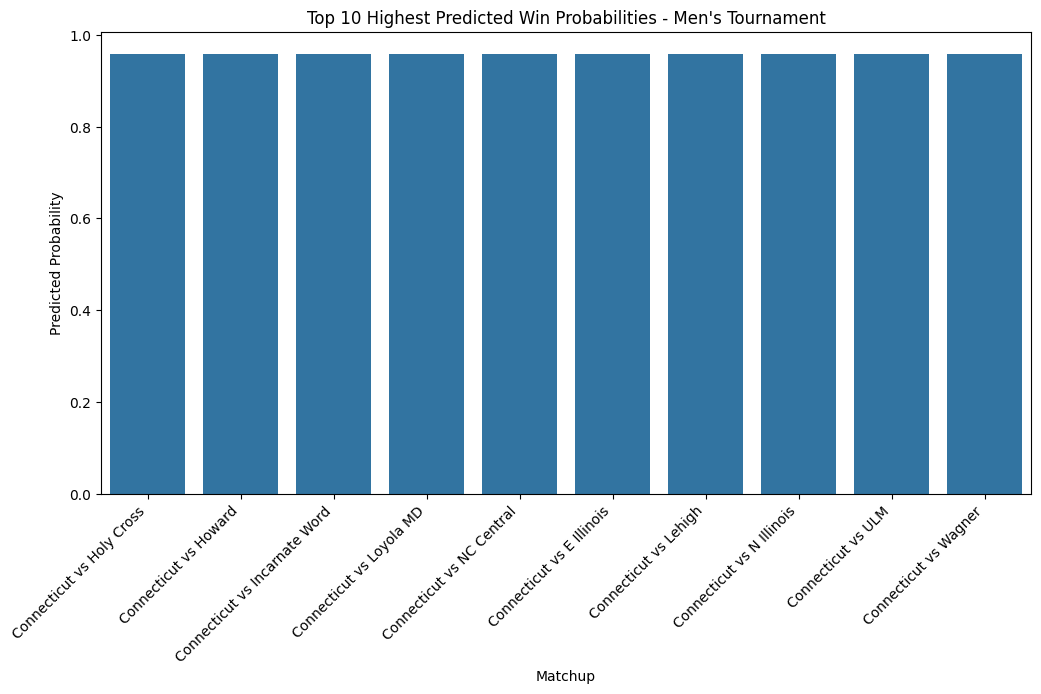

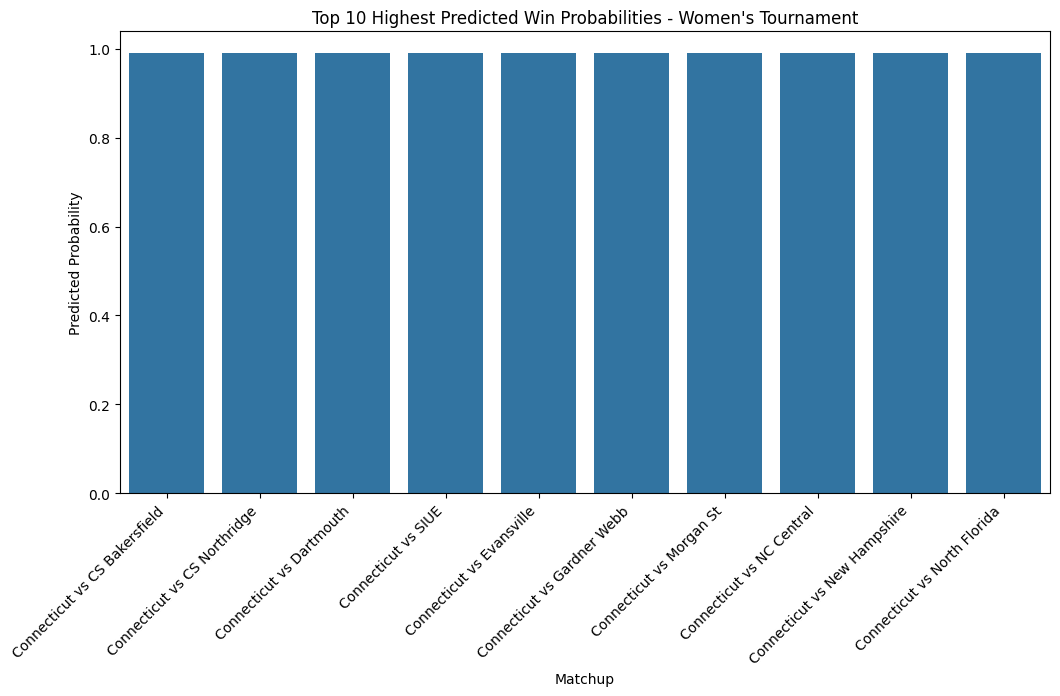

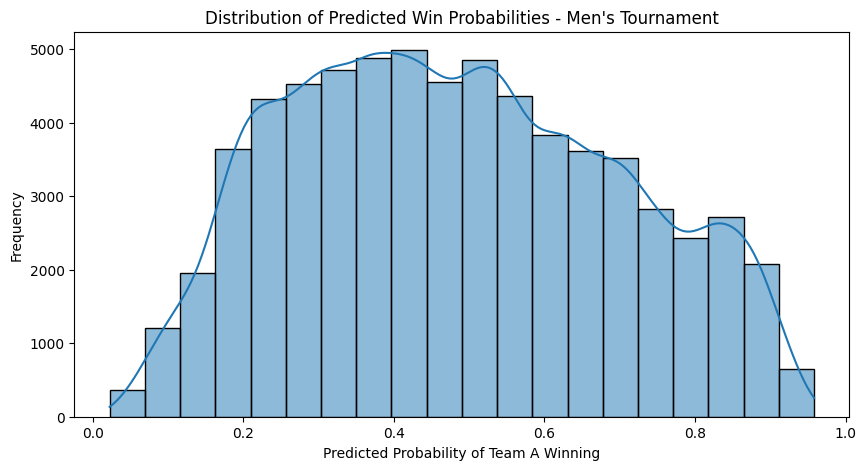

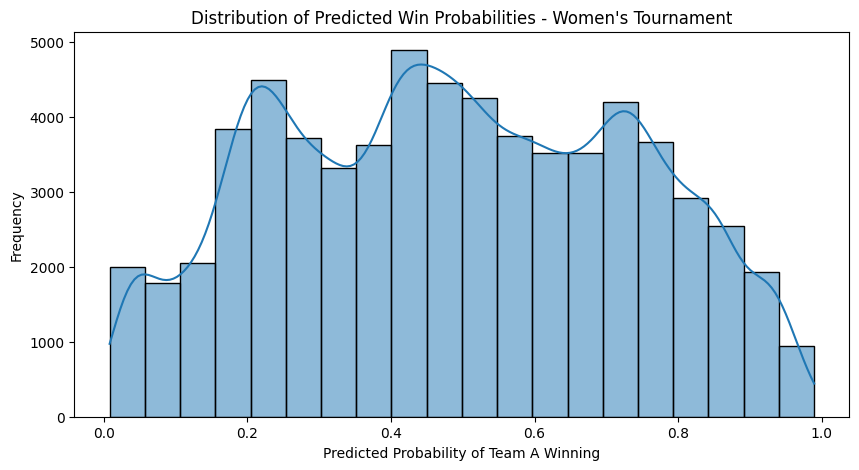

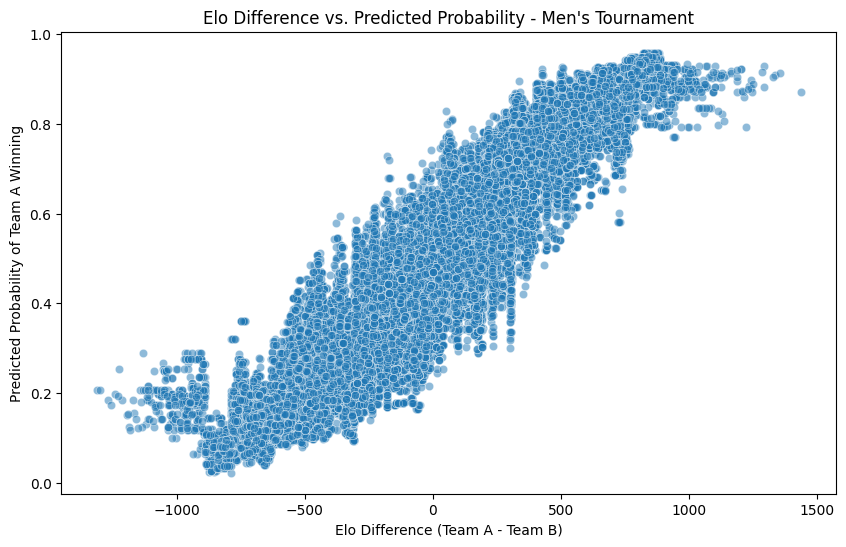

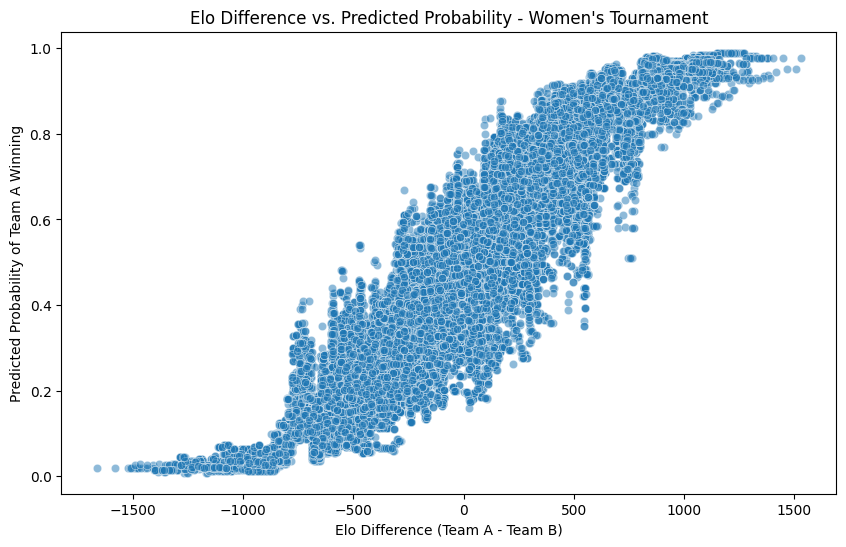

In [ ]:
### ---------------- STEP 6: Generate Visualizations for Both Men’s & Women’s Tournaments ---------------- ###
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart: Top 10 matchups with the highest predicted win probability.
# Histogram: Distribution of predicted win probabilities.
# Scatter Plot: Elo rating difference vs. predicted probability.

# Load enriched predictions for men and women
stage2_men = pd.read_csv("NCAA_EnrichedPredictions_MenStage2_EngraciaBatista.csv")
stage2_women = pd.read_csv("NCAA_EnrichedPredictions_WomenStage2_EngraciaBatista.csv")

### ------------------ Visualization 1: Top 10 Highest Predicted Win Probabilities ------------------ ###

def plot_top_teams(stage2_data, title):
    """Plot the top 10 matchups with the highest predicted win probability."""
    top_teams = stage2_data.nlargest(10, "Pred")

    plt.figure(figsize=(12, 6))
    sns.barplot(y=top_teams["Pred"], x=top_teams["TeamA_Name"] + " vs " + top_teams["TeamB_Name"])
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Matchup")
    plt.ylabel("Predicted Probability")
    plt.title(title)
    plt.show()

# Plot for Men
plot_top_teams(stage2_men, "Top 10 Highest Predicted Win Probabilities - Men's Tournament")

# Plot for Women
plot_top_teams(stage2_women, "Top 10 Highest Predicted Win Probabilities - Women's Tournament")

### ------------------ Visualization 2: Distribution of Predicted Win Probabilities ------------------ ###

def plot_probability_distribution(stage2_data, title):
    """Plot a histogram of predicted win probabilities."""
    plt.figure(figsize=(10, 5))
    sns.histplot(stage2_data["Pred"], bins=20, kde=True)
    plt.xlabel("Predicted Probability of Team A Winning")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Plot for Men
plot_probability_distribution(stage2_men, "Distribution of Predicted Win Probabilities - Men's Tournament")

# Plot for Women
plot_probability_distribution(stage2_women, "Distribution of Predicted Win Probabilities - Women's Tournament")

### ------------------ Visualization 3: Elo Difference vs. Predicted Probability ------------------ ###

def plot_elo_vs_probability(stage2_data, title):
    """Scatter plot of Elo difference vs. predicted probability."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=stage2_data["EloDiff"], y=stage2_data["Pred"], alpha=0.5)
    plt.xlabel("Elo Difference (Team A - Team B)")
    plt.ylabel("Predicted Probability of Team A Winning")
    plt.title(title)
    plt.show()

# Plot for Men
plot_elo_vs_probability(stage2_men, "Elo Difference vs. Predicted Probability - Men's Tournament")

# Plot for Women
plot_elo_vs_probability(stage2_women, "Elo Difference vs. Predicted Probability - Women's Tournament")
